<a href="https://colab.research.google.com/github/g185/AMLrepository/blob/main/RecipeNet/AML_Project_Giuliano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Download and unzip Dataset***


*   Create folders
*   Download Recipe 5K + Annotations in drive
*   Unzip files in folder



In [4]:
#Create folders for models and datasets
!mkdir "/content/drive/My Drive/RecipeNet" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/download" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/extracted" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/preprocessed" 
!mkdir "/content/drive/My Drive/RecipeNet/model" 

#Scarica dataset
#Trascina i 3 zip

#Unzip
"""
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Recipes5k.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/archive.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Ingredients101.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"

"""


mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/datasets’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/datasets/download’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/datasets/extracted’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/model’: File exists


'\n!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Recipes5k.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"\n!unzip "/content/drive/My Drive/RecipeNet/datasets/download/archive.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"\n!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Ingredients101.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"\n\n'

#***Imports and Drive Mount***

In [3]:
#Imports
import sys
import time
import os
import json
import numpy as np 
import pandas as pd 
from tqdm import tqdm, tqdm_notebook, tnrange
import sys
import cv2
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from glob import glob
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.preprocessing import MultiLabelBinarizer

#Cuda
device = torch.device("cuda")
torch.manual_seed(42) # try and make the results more reproducible
print(torch.cuda.get_device_name(0))

#Drive Mount
from google.colab import drive
drive.mount('/content/drive')


Tesla P100-PCIE-16GB
Mounted at /content/drive


#***Project Parameters***


In [19]:
params = {}
params["root"] = "/content/drive/My Drive/RecipeNet/"
params["images_dir"] = params["root"] + "datasets/extracted/images/" 
params["ingredients_per_class"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/ingredients_simplified.txt" 
params["classes"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/classes.txt" 
params["baseIngredients_dir"] = params["root"] + "datasets/extracted/Ingredients101/ingredients_simplification/baseIngredients.txt" 
params["epochs"] = 35
params["batch_size"] = 64
params["img_size"] = (384,384)
params["fast_training"] = False

print(params["images_dir"])

/content/drive/My Drive/RecipeNet/datasets/extracted/images/


#***Data extraction and preprocessing***


In [18]:
#Ingredients x class
f = open(params["ingredients_per_class"], "r")
ingredients = f.read().split('\n')
f.close()

#Classes
f = open(params["classes"], "r")
classes = f.read().split('\n')
f.close()

#Ingredients
f = open(params["baseIngredients_dir"], "r")
base_ing = f.read().split('\n')
base_ing = base_ing[0].split(",")
f.close()

#train images
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/train_images.txt", "r")
train_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/train_labels.txt", "r")
train_labels = f.read().split('\n')
f.close()

#validation images
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/val_images.txt", "r")
val_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/val_labels.txt", "r")
val_labels = f.read().split('\n')
f.close()

#test images
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/test_images.txt", "r")
test_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/test_labels.txt", "r")
test_labels = f.read().split('\n')
f.close()

#________


#list of string in list of list of tokens
new_ingredients = [arr.split(",") for arr in ingredients]

#binary encode ingredients
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(new_ingredients),columns=mlb.classes_) 
df["target"] = classes
food_dict = df

#___________

train_images = [params["images_dir"] + s + ".jpg" for s in train_images]
all_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})
val_images = [params["images_dir"] + s + ".jpg" for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})
test_images = [params["images_dir"] + s + ".jpg" for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})
all_img_df = all_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]



all_img_df['class_name'] = all_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
val_img_df['class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df['class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])

#_______


food_dict = food_dict.drop('', 1)

#Dataframe for train images
new_data = []
for index, row in all_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = class_id
    #print(binary_encod)
    #print((list(binary_encod.columns.values)))
    #print(len(np.array(binary_encod)[0]))
    new_data.append(np.array(binary_encod)[0])


    
col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)


#_____
val_data = []
for index, row in val_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    val_data.append(np.array(binary_encod)[0])
val_df = pd.Datafame(val_data, columns = col_names)

#_____
test_data = []
for index, row in test_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    test_data.append(np.array(binary_encod)[0])


test_df = pd.DataFrame(test_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: ignored

#***DataGenerator***


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


../input/food41/images/macaroni_and_cheese/1937605.jpg



error: ignored

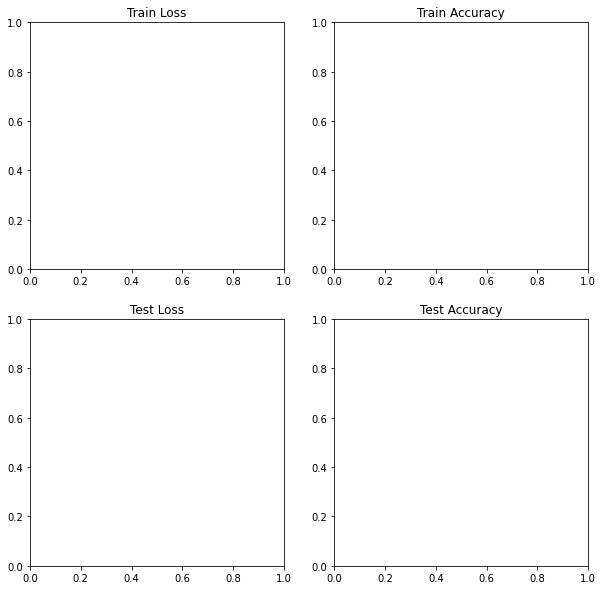

In [31]:
class DataWrapper(data.Dataset):
    ''' Data wrapper for pytorch's data loader function '''
    def __init__(self, image_df, resize):
        self.dataset = image_df
        self.resize = resize

    def __getitem__(self, index):
        c_row = self.dataset.iloc[index]
        target_arr = []
        for item in c_row[targets].values:
            target_arr.append(item)
        #print(target_arr)
        image_path, target = c_row['path'], torch.from_numpy(np.array(target_arr)).float()  #image and target
        #read as rgb image, resize and convert to range 0 to 1
        image = cv2.imread(image_path, 1)
        if self.resize:
            image = cv2.resize(image, IMG_SIZE)/255.0 
        else:
            image = image/255.0
        image = (torch.from_numpy(image.transpose(2,0,1))).float() #NxCxHxW
        return image, target

    def __len__(self):
        return self.dataset.shape[0]

#***Model definition***